In [1211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

import warnings
warnings.filterwarnings("ignore")

### Data Preparation and Filtering

In [1212]:
income_grouping_2019 = pd.read_csv('./datasets/World Bank Income Grouping 2019.csv')

# Drop all records with NaN values
income_grouping_2019.dropna(inplace=True)
income_grouping_2019.reset_index(inplace=True, drop=True)

income_grouping_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   region_code      109 non-null    object
 1   region_name      109 non-null    object
 2   country_code     109 non-null    object
 3   country_name     109 non-null    object
 4   income_grouping  109 non-null    object
dtypes: object(5)
memory usage: 4.4+ KB


In [1213]:
ihd_df = pd.read_csv('./datasets/Ischaemic Heart Disease.csv')
ihd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296604 entries, 0 to 296603
Data columns (total 12 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   region_code                                           296604 non-null  object 
 1   region_name                                           296604 non-null  object 
 2   country_code                                          296604 non-null  object 
 3   country_name                                          296604 non-null  object 
 4   year                                                  296604 non-null  int64  
 5   sex                                                   296604 non-null  object 
 6   age_group_code                                        296604 non-null  object 
 7   age_group                                             296604 non-null  object 
 8   num_of_death                                

In [1214]:
ihd_df = pd.read_csv('./datasets/Ischaemic Heart Disease.csv')

# Remove all records with zero (0) number of deaths
# ihd_df_filtered = ihd_df[ihd_df['num_of_death'].notna()]

# NOTE: Records before 1963 were removed due to missing data for Low Middle Income
# ihd_df_filtered = ihd_df_filtered.query("sex == ['Male', 'Female'] and age_group != ['[All]', '[Unknown]'] and (year >= 1963 and year < 2020) and num_of_death != 0")
ihd_df_filtered = ihd_df.query("sex == ['Male', 'Female'] and age_group != ['[All]', '[Unknown]'] and (year >= 1963 and year < 2020)")

# Fill all NaN cells with 0
ihd_df_filtered = ihd_df_filtered.fillna(0)

ihd_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119826 entries, 26 to 296540
Data columns (total 12 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   region_code                                           119826 non-null  object 
 1   region_name                                           119826 non-null  object 
 2   country_code                                          119826 non-null  object 
 3   country_name                                          119826 non-null  object 
 4   year                                                  119826 non-null  int64  
 5   sex                                                   119826 non-null  object 
 6   age_group_code                                        119826 non-null  object 
 7   age_group                                             119826 non-null  object 
 8   num_of_death                               

In [1215]:
# Merge the selected fields from Ischeamic Heart Disease and Income Grouping 2019 tables
ihd_with_ig_df = ihd_df_filtered[['country_code', 'country_name', 'year', 'sex', 'age_group', 'num_of_death', 'death_rate_per_100000']].merge(income_grouping_2019[['country_code', 'income_grouping']], on='country_code')
ihd_with_ig_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118436 entries, 0 to 118435
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country_code           118436 non-null  object 
 1   country_name           118436 non-null  object 
 2   year                   118436 non-null  int64  
 3   sex                    118436 non-null  object 
 4   age_group              118436 non-null  object 
 5   num_of_death           118436 non-null  float64
 6   death_rate_per_100000  118436 non-null  float64
 7   income_grouping        118436 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 8.1+ MB


### Method Declaration

In [1216]:
def groupByIncomeGroupingAndYear(df, income_grouping):
    # Group the records, then aggregate the records by Year
    df_grp_by_income = df.get_group(income_grouping)
    df_grp_by_income_and_year = df_grp_by_income[['year', 'death_rate_per_100000']].groupby('year', as_index=False).agg(death_rate_per_100000 = ('death_rate_per_100000', 'mean'))

    #print(f"Income Grouping: {income_grouping}\n")
    #print(df_grp_by_income_and_year)
    
    return df_grp_by_income_and_year


def groupByIncomeGroupingAndSex(df, sex):
    # Group the records, then aggregate the records by Year
    df_grp_by_sex = df.get_group(sex)
    df_grp_by_sex_and_year = df_grp_by_sex[['year', 'death_rate_per_100000']].groupby('year', as_index=False).agg(death_rate_per_100000 = ('death_rate_per_100000', 'mean'))

    #print(f"Sex: {sex}\n")
    #print(df_grp_by_sex_and_year)
    
    return df_grp_by_sex_and_year

### Data Analysis on Income Grouping

In [1217]:
# Group data by income_grouping
ihd_with_ig_grp_income = ihd_with_ig_df.groupby(['income_grouping']) 

# Display summary statistics of 'death_rate_per_100000' for each income group   
ihd_with_ig_grp_income['death_rate_per_100000'].describe()  

,count,mean,std,min,25%,50%,75%,max
income_grouping,,,,,,,,
High Income,63220.0,603.834396,1301.872259,0.0,4.856543,73.367973,570.819128,26000.00000
Low Middle Income,12606.0,840.988384,2081.221246,0.0,4.325224,48.726672,476.574560,20608.95823
Upper Middle Income,42610.0,494.445236,1192.770590,0.0,4.332249,59.019088,409.224867,19016.29073


In [1218]:
# Group the records by 'High Income' bracket, then aggregate the records by Year
ihd_with_ig_grp_high_income_and_year = groupByIncomeGroupingAndYear(ihd_with_ig_grp_income, 'High Income')

year_by_high_income = ihd_with_ig_grp_high_income_and_year['year']
death_rate_per_100000_by_high_income = ihd_with_ig_grp_high_income_and_year['death_rate_per_100000']

In [1219]:
# Group the records by 'Upper Middle Income' bracket, then aggregate the records by Year
ihd_with_ig_grp_upper_mid_income_and_year = groupByIncomeGroupingAndYear(ihd_with_ig_grp_income, 'Upper Middle Income')

year_by_upper_mid_income = ihd_with_ig_grp_upper_mid_income_and_year['year']
death_rate_per_100000_by_upper_mid_income = ihd_with_ig_grp_upper_mid_income_and_year['death_rate_per_100000']

In [1220]:
# Group the records by 'Low Middle Income' bracket, then aggregate the records by Year
ihd_with_ig_grp_low_mid_income_and_year = groupByIncomeGroupingAndYear(ihd_with_ig_grp_income, 'Low Middle Income')

year_by_low_mid_income = ihd_with_ig_grp_low_mid_income_and_year['year']
death_rate_per_100000_by_low_mid_income = ihd_with_ig_grp_low_mid_income_and_year['death_rate_per_100000']

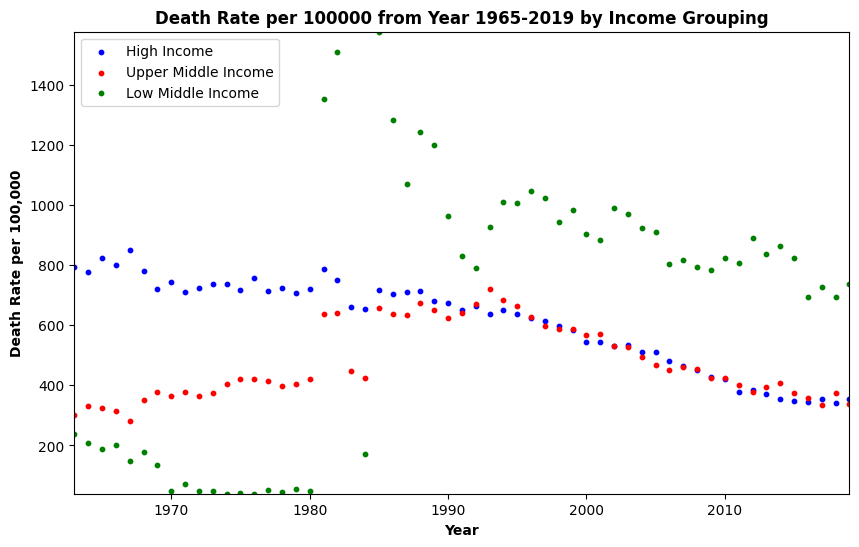

In [1221]:
# Plot the graph of Death Rate per 100000 for each Year based on Income Grouping
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111)
ax1.set_xmargin(0)
ax1.set_ymargin(0)
ax1.set_xlabel("Year", fontdict={'weight':'bold'})
ax1.set_ylabel("Death Rate per 100,000", fontdict={'weight':'bold'})
ax1.set_title("Death Rate per 100000 from Year 1965-2019 by Income Grouping", fontdict={'size':'large', 'weight':'bold'})

ax1.scatter(year_by_high_income, death_rate_per_100000_by_high_income, s=10, c='b', label='High Income')
ax1.scatter(year_by_upper_mid_income, death_rate_per_100000_by_upper_mid_income, s=10, c='r', label='Upper Middle Income')
ax1.scatter(year_by_low_mid_income, death_rate_per_100000_by_low_mid_income, s=10, c='g', label='Low Middle Income')
plt.legend(loc='upper left')
plt.show()

### Data Analysis on Sex

In [1222]:
# Group data by income_grouping
ihd_with_ig_grp_sex = ihd_with_ig_df.groupby(['sex']) 

# Display summary statistics of 'death_rate_per_100000' for each income group   
ihd_with_ig_grp_sex['death_rate_per_100000'].describe()  

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
Female,57495.0,499.593275,1269.409402,0.0,3.114258,38.030872,354.089993,22333.33333
Male,60941.0,674.752732,1460.608811,0.0,6.956038,103.960396,633.888048,26000.00000


In [1223]:
# Group the records by Male, then aggregate the records by Year
ihd_with_ig_grp_male_and_year = groupByIncomeGroupingAndSex(ihd_with_ig_grp_sex, 'Male')

year_by_male = ihd_with_ig_grp_male_and_year['year']
death_rate_per_100000_by_male = ihd_with_ig_grp_male_and_year['death_rate_per_100000']

In [1224]:
# Group the records by Female, then aggregate the records by Year
ihd_with_ig_grp_female_and_year = groupByIncomeGroupingAndSex(ihd_with_ig_grp_sex, 'Female')

year_by_female = ihd_with_ig_grp_female_and_year['year']
death_rate_per_100000_by_female = ihd_with_ig_grp_female_and_year['death_rate_per_100000']

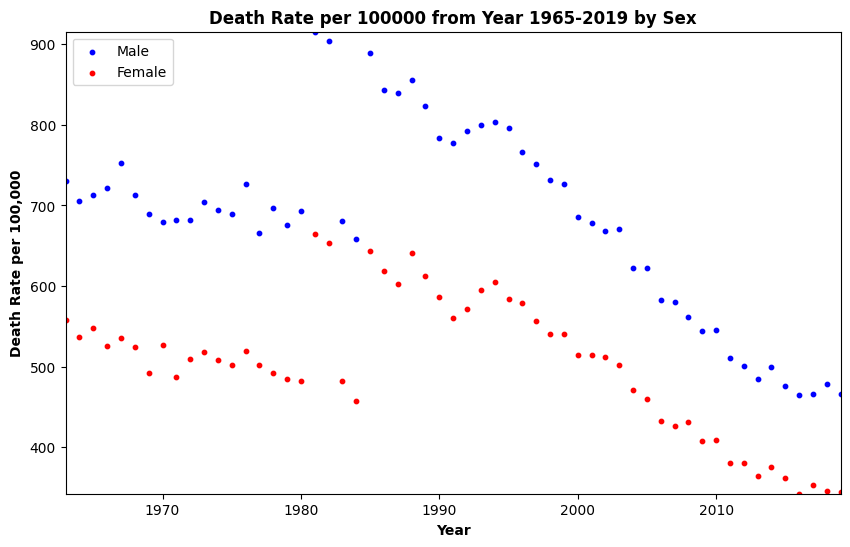

In [1225]:
# Plot the graph of Death Rate per 100000 for each Year based on Sex
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111)
ax1.set_xmargin(0)
ax1.set_ymargin(0)
ax1.set_xlabel("Year", fontdict={'weight':'bold'})
ax1.set_ylabel("Death Rate per 100,000", fontdict={'weight':'bold'})
ax1.set_title("Death Rate per 100000 from Year 1965-2019 by Sex", fontdict={'size':'large', 'weight':'bold'})

ax1.scatter(year_by_male, death_rate_per_100000_by_male, s=10, c='b', label='Male')
ax1.scatter(year_by_female, death_rate_per_100000_by_female, s=10, c='r', label='Female')
plt.legend(loc='upper left')
plt.show()

### Data Analysis on Age Group

In [1226]:
# Regroup the category of the previous age group
# Reference for age grouping: https://www.statcan.gc.ca/en/concepts/definitions/age2

ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[0]', 'Children', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[1-4]', 'Children', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[5-9]', 'Children', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[10-14]', 'Children', ihd_with_ig_df['age_group'])

ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[15-19]', 'Youth', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[20-24]', 'Youth', ihd_with_ig_df['age_group'])

ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[25-29]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[30-34]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[35-39]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[40-44]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[45-49]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[50-54]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[55-59]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[60-64]', 'Adults', ihd_with_ig_df['age_group'])

ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[65-69]', 'Seniors', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[70-74]', 'Seniors', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[75-79]', 'Seniors', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[80-84]', 'Seniors', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[85+]', 'Seniors', ihd_with_ig_df['age_group'])


# Group data by income_grouping
ihd_with_ig_df.groupby(['age_group'])['death_rate_per_100000'].describe()

,count,mean,std,min,25%,50%,75%,max
age_group,,,,,,,,
Adults,60797.0,85.845599,152.748290,0.0,5.820854,25.274098,94.481949,1711.553829
Children,7056.0,1.534775,8.196260,0.0,0.113150,0.303107,0.852576,420.609884
Seniors,41159.0,1569.567071,1980.799974,0.0,372.407542,868.928057,1943.845816,26000.000000
Youth,9424.0,1.318576,1.861419,0.0,0.365452,0.775607,1.635553,60.168472


### Logistic Regression
Get the probability that Ishaemic Heart Disease is the cause of death for each income group 

##### Data Preparation: Converting Categorical Features

In [1227]:
# Check the data types of the fields
ihd_with_ig_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118436 entries, 0 to 118435
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country_code           118436 non-null  object 
 1   country_name           118436 non-null  object 
 2   year                   118436 non-null  int64  
 3   sex                    118436 non-null  object 
 4   age_group              118436 non-null  object 
 5   num_of_death           118436 non-null  float64
 6   death_rate_per_100000  118436 non-null  float64
 7   income_grouping        118436 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 8.1+ MB


In [1228]:
# Convert income grouping to dummy variables
income_grouping_df = pd.get_dummies(ihd_with_ig_df['income_grouping'])
income_grouping_df.columns = ['high_income', 'low_middle_income', 'upper_middle_income']

# Convert sex to dummy variables
male_gender_df = pd.get_dummies(ihd_with_ig_df['sex'], drop_first=True)
male_gender_df.columns = ['male_gender']

# Convert age grouping to dummy variables
age_grouping_df = pd.get_dummies(ihd_with_ig_df['age_group'])
age_grouping_df.columns = ['adults', 'children', 'seniors', 'youth']

# Drop sex, age grouping and income grouping, and other unnecessary columns
ihd_with_ig_df_dummy = ihd_with_ig_df.copy()
ihd_with_ig_df_dummy.drop(['country_code', 'country_name', 'sex', 'income_grouping', 'year', 'age_group', 'death_rate_per_100000'], axis=1, inplace=True)

# Add the dummy columns
ihd_with_ig_df_dummy = pd.concat([ihd_with_ig_df_dummy, male_gender_df, age_grouping_df, income_grouping_df], axis=1, verify_integrity=True)
ihd_with_ig_df_dummy.head(5)

,num_of_death,male_gender,adults,children,seniors,youth,high_income,low_middle_income,upper_middle_income
0,1.0,1,0,0,0,1,0,0,1
1,1.0,1,0,0,0,1,0,0,1
2,6.0,1,1,0,0,0,0,0,1
3,7.0,1,1,0,0,0,0,0,1
4,5.0,1,1,0,0,0,0,0,1


<AxesSubplot: >

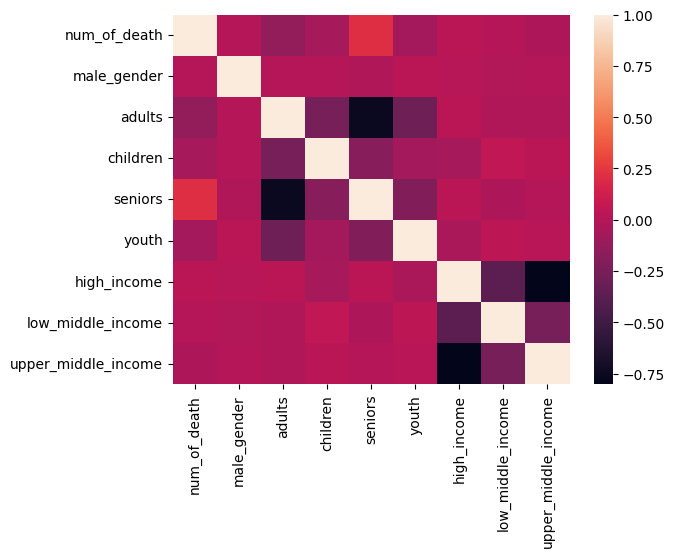

In [1229]:
# Check independence between features (Dark -> Data are more correlated)
# NOTE: In Logistic Regression, the features are assumed to be independent from one another
sb.heatmap(ihd_with_ig_df_dummy.corr())

### Method Declaration

In [1230]:
def evaluateModel(LogReg, x_train, x_test, y_train, y_test):
    y_pred = LogReg.predict(x_test)
    print(f"Score: {LogReg.score(x_test, y_test)}\n")

    # Classification report without cross-validation
    print("Classification Report")
    print(classification_report(y_test, y_pred))

    # k-fold cross-validation and confusion matrices
    y_train_pred = cross_val_predict(LogReg, x_train, y_train, cv=5)
    print("Confusion Matrix")
    print(confusion_matrix(y_train, y_train_pred), "\n")

    print(f"Precision Score: {precision_score(y_train, y_train_pred)}")

    

### Model Creation for High Income Group
##### Generate Train, Test, Split Datasets. Build the model.

In [1231]:
# Split data into training data sets and test data sets
x_train, x_test, y_train, y_test = train_test_split(ihd_with_ig_df_dummy.drop(['high_income', 'upper_middle_income', 'low_middle_income'], axis=1), ihd_with_ig_df_dummy['high_income'], test_size=0.3, random_state=0)

print("Train: ", x_train.shape, y_train.shape)
print("Test: ", x_test.shape, y_test.shape)

LogReg = LogisticRegression(solver='lbfgs')
LogReg.fit(x_train, y_train)

Train:  (82905, 6) (82905,)
Test:  (35531, 6) (35531,)


LogisticRegression()

##### Model Evaluation

In [1232]:
evaluateModel(LogReg, x_train, x_test, y_train, y_test)

Score: 0.5494357040330978

Classification Report
              precision    recall  f1-score   support

           0       0.55      0.17      0.26     16551
           1       0.55      0.88      0.68     18980

    accuracy                           0.55     35531
   macro avg       0.55      0.53      0.47     35531
weighted avg       0.55      0.55      0.48     35531

Confusion Matrix
[[ 1268 37397]
 [  998 43242]] 

Precision Score: 0.5362417688711417


### Model Creation for Upper Middle Income Group
##### Generate Train and Test Datasets. Build the model.

In [1233]:
# Split data into training data sets and test data sets
x_train, x_test, y_train, y_test = train_test_split(ihd_with_ig_df_dummy.drop(['high_income', 'upper_middle_income', 'low_middle_income'], axis=1), ihd_with_ig_df_dummy['upper_middle_income'], test_size=0.3, random_state=0)

print("Train: ", x_train.shape, y_train.shape)
print("Test: ", x_test.shape, y_test.shape)

LogReg = LogisticRegression(solver='lbfgs')
LogReg.fit(x_train, y_train)

Train:  (82905, 6) (82905,)
Test:  (35531, 6) (35531,)


LogisticRegression()

##### Model Evaluation

In [1234]:
evaluateModel(LogReg, x_train, x_test, y_train, y_test)

Score: 0.6424249247136303

Classification Report
              precision    recall  f1-score   support

           0       0.64      1.00      0.78     22826
           1       0.00      0.00      0.00     12705

    accuracy                           0.64     35531
   macro avg       0.32      0.50      0.39     35531
weighted avg       0.41      0.64      0.50     35531

Confusion Matrix
[[53000     0]
 [29905     0]] 

Precision Score: 0.0


### Model Creation for Low Middle Income Group
##### Generate Train and Test Datasets. Build the model.

In [1235]:
# Split data into training data sets and test data sets
x_train, x_test, y_train, y_test = train_test_split(ihd_with_ig_df_dummy.drop(['high_income', 'upper_middle_income', 'low_middle_income'], axis=1), ihd_with_ig_df_dummy['low_middle_income'], test_size=0.3, random_state=0)

print("Train: ", x_train.shape, y_train.shape)
print("Test: ", x_test.shape, y_test.shape)

LogReg = LogisticRegression(solver='lbfgs')
LogReg.fit(x_train, y_train)

Train:  (82905, 6) (82905,)
Test:  (35531, 6) (35531,)


LogisticRegression()

##### Model Evaluation

In [1236]:
evaluateModel(LogReg, x_train, x_test, y_train, y_test)

Score: 0.8917564943288959

Classification Report
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     31685
           1       0.00      0.00      0.00      3846

    accuracy                           0.89     35531
   macro avg       0.45      0.50      0.47     35531
weighted avg       0.80      0.89      0.84     35531

Confusion Matrix
[[74145     0]
 [ 8760     0]] 

Precision Score: 0.0


### Make test prediction